In [2]:
import os

repo_dir = os.environ.get("REPO_DIR")

code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")

os.chdir(code_dir)

import sys
sys.path.append(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import sklearn 
import pandas as pd
from importlib import reload

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns

from scipy.stats import spearmanr, mode

import geopandas as gpd
import rasterio
import zarr

import gc

import warnings

from mosaiks.utils.imports import *

from mosaiks.utils.io import weighted_groupby
from affine import Affine

import cartopy.crs as ccrs
# Key prediction functions are here
from prediction_utils import (X_matrix_to_demeaned_X,df_to_demeaned_y_vars, flatten_raster,rasterize_df,
make_train_pred_scatterplot as make_scatterplot, cv_solve, solver_kwargs, get_truth_preds_from_kfold_results,
                             predict_y_from_kfold_dict, generalized_demean, upscale_grid_vector)

import dask.dataframe as dd

# Predicting grid level HDI

In this notebook, we generate HDI at the grid level. In order to produce grid level estimates of HDI, we will use MOSAIKS features that have been aggregated from the native tile level (.01 x .01 degrees) up to .1 x .1 degree resolution. This aggregation was done using native tile-level weights from the GHS-POP data product.

We will need 48GB of grid MOSAIKS level features to run this, which makes replication challenging for some users. MOSAIKS features at the grid level are available at `siml.berkeley.edu`.

### First, we need nightlight values at the .1 x .1 degree (tile) level

We are going to feature each grid cell as if its an administrative polygon. We will use the same NL featurization procedure as done in `make_viirs_nl_features_GHS_pop.ipynb`.

In [2]:
bin_path = (data_dir+
           "int/VIIRS/VIIRS_feature_bin_widths.p")
percentile_bins = pickle.load(open(bin_path, "rb"))

## Bin widths are determined based on VIIRS distribution. 
# See `make_viirs_nl_features_GHS_pop.ipynb` where this data is written

In [3]:
def binned(a, w, bins=percentile_bins):
    d =  np.histogram(a, bins=bins, density = False, weights=w)
    perc_in_each_bin = d[0]/np.sum(w)
    return perc_in_each_bin

In [4]:
## READ AND FLATTEN RAW VIIRS RASTER

# path = (data_dir+"raw/VIIRS/VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average_masked.dat.tif")

# src = rasterio.open(path)
# arr = src.read(1)
# x,y,vals = flatten_raster(arr, src.transform)
# del arr
# src.close()

In [5]:
## READ AND FLATTEN GHS POP RASTER THAT HAS BEEN REFORMATTED TO MATCH VIIRS

# THIS REFORMATTED RASTER IS CREATED IN `make_viirs_nl_features_GHS_pop.ipynb`

# src_pop_match = rasterio.open(data_dir + "int/VIIRS/GHS_pop_density_match_viirs_rasterio_method.tif")
# arr = src_pop_match.read(1)
# _,_,pop_vals = flatten_raster(arr, src.transform)
# del arr
# src_pop_match.close()

In [6]:
## CONVERT .004166 DEGREE RESOLUTION to .1 DEGREE RESOLUTION
# x = upscale_grid_vector(x,1)
# y = upscale_grid_vector(y,1)

# nl = pd.DataFrame({"lon":x,"lat":y,"nl":vals, "pop_weights":pop_vals})
# nl.to_pickle(data_dir+"int/VIIRS/nl_flat_with_GHS_POP_weights_.01x.01")
#nl = pd.read_pickle(data_dir+"int/VIIRS/nl_flat_with_GHS_POP_weights_.01x.01")

In [7]:
## TO DEAL WITH MEMORY CONSTRAINTS, WE ARE GOING TO DROP ALL THE LOCATIONS THAT DO NOT HAVE
## ANY POPULATION. WE DO NOT WANT TO PRODUCE ESTIMATES IN THESE PLACES ANYWAY. THEY SHOULD BE POP MASKED.
## THIS ALSO IMPLICITLY APPLIES OUR POP MASK SINCE WE WON'T PRODUCE ESTIMATES HERE

# THIS POPULATION DATA PRODUCT IS CREATED IN `population_counts_for_ADM_polygons.ipynb` 

pop_df = pd.read_pickle(data_dir + "int/GHS_pop/pop_count_sums_for_.1x1_grid.p")
pop_df = pop_df[pop_df["pop_count"]!=0]

In [8]:
pop_df

,lon10,lat10,pop_count
722,-180.05,-16.85,1.896578
723,-180.05,-16.75,15.608837
726,-180.05,-16.45,1.300960
2504,-179.95,-16.85,5.689734
2505,-179.95,-16.75,4329.009187
...,...,...,...
6415924,179.95,-16.65,326.060836
6415925,179.95,-16.55,1518.435504
6415926,179.95,-16.45,553.616037
6415928,179.95,-16.25,294.302265


In [9]:
#nl_subsetted = pop_df.merge(nl, how="left", left_on=["lon10","lat10"],right_on=["lon","lat"]).dropna()

#nl_subsetted.to_pickle(data_dir + "int/VIIRS/nl_flat_with_GHS_POP_weights_.01x.01_subsetted.p")

#del nl

Now we have a dataframe at the correct resolution, an matching lists of VIIRS values and pop weights in two of the columns. We just need to featurize every grid cell

Now we have a dataframe at the correct resolution, a matching lists of VIIRS values and pop weights in two of the columns. We just need to featurize every grid cell

In [10]:
# nl_subsetted = pd.read_pickle(data_dir + "int/VIIRS/nl_flat_with_GHS_POP_weights_.01x.01_subsetted.p")
# nl_subsetted_g =  nl_subsetted.groupby(["lon","lat"])
# nl_arrays = nl_subsetted_g["nl"].apply(np.array)
# pop_arrays = nl_subsetted_g["pop_weights"].apply(np.array)

In [11]:
# fts = []

# for i in range(len(nl_arrays)):
#     a = nl_arrays.iloc[i]
#     w = pop_arrays.iloc[i]
    
# #     ft = binned(a,w)
#     fts.append(ft)

In [12]:
# nl_feats_df = pd.DataFrame(fts, index= nl_arrays.index)
# nl_feats_df.to_pickle(data_dir + "int/VIIRS/nl_weighted_fts_grid_.1x.1.p")

We have the non-linar NL features for every .1 x .1 degree grid cell.

In [13]:
nl_feats_df = pd.read_pickle(data_dir + "int/VIIRS/nl_weighted_fts_grid_.1x.1.p")
nl_feats_df.columns = "perc_pixels_in_bin_" + pd.Series(np.arange(0,21).astype(str))

In [14]:
nl_feats_df

perc_pixels_in_bin_0  perc_pixels_in_bin_1  \
lon     lat                                                  
-179.95 -16.85              0.223597              0.455290   
        -16.75              0.713775              0.217717   
        -16.65              1.000000              0.000000   
        -16.55              1.000000              0.000000   
        -16.45              1.000000              0.000000   
...                              ...                   ...   
 179.95 -16.65              1.000000              0.000000   
        -16.55              1.000000              0.000000   
        -16.45              1.000000              0.000000   
        -16.25              1.000000              0.000000   
        -16.15              1.000000              0.000000   

                perc_pixels_in_bin_2  perc_pixels_in_bin_3  \
lon     lat                                                  
-179.95 -16.85              0.321113              0.000000   
        -16.75              0.018594              0.005643   
        -16.65              0.000000              0.000000   
        -16.55              0.000000              0.000000   
        -16.45              0.000000              0.000000   
...                              ...                   ...   
 179.95 -16.65              0.000000              0.000000   
        -16.55              0.000000              0.000000   
        -16.45              0.000000              0.000000   
        -16.25              0.000000              0.000000   
        -16.15              0.000000              0.000000   

                perc_pixels_in_bin_4  perc_pixels_in_bin_5  \
lon     lat                                                  
-179.95 -16.85              0.000000              0.000000   
        -16.75              0.022388              0.021047   
        -16.65              0.000000              0.000000   
        -16.55              0.000000              0.000000   
        -16.45              0.000000              0.000000   
...                              ...                   ...   
 179.95 -16.65              0.000000              0.000000   
        -16.55              0.000000              0.000000   
        -16.45              0.000000              0.000000   
        -16.25              0.000000              0.000000   
        -16.15              0.000000              0.000000   

                perc_pixels_in_bin_6  perc_pixels_in_bin_7  \
lon     lat                                                  
-179.95 -16.85              0.000000                   0.0   
        -16.75              0.000836                   0.0   
        -16.65              0.000000                   0.0   
        -16.55              0.000000                   0.0   
        -16.45              0.000000                   0.0   
...                              ...                   ...   
 179.95 -16.65              0.000000                   0.0   
        -16.55              0.000000                   0.0   
        -16.45              0.000000                   0.0   
        -16.25              0.000000                   0.0   
        -16.15              0.000000                   0.0   

                perc_pixels_in_bin_8  perc_pixels_in_bin_9  ...  \
lon     lat                                                 ...   
-179.95 -16.85                   0.0                   0.0  ...   
        -16.75                   0.0                   0.0  ...   
        -16.65                   0.0                   0.0  ...   
        -16.55                   0.0                   0.0  ...   
        -16.45                   0.0                   0.0  ...   
...                              ...                   ...  ...   
 179.95 -16.65                   0.0                   0.0  ...   
        -16.55                   0.0                   0.0  ...   
        -16.45                   0.0                   0.0  ...   
        -16.25                   0.0               

### We need the country dense grid tiles for each country

If a .1 x .1 degree grid cell intersects two ADM1 regions, we assign the ADM1 regiun with the most .01 x .01 tiles contained in .1 x .1 degree cell. This is needed for recentering the grid-level data product.

In [15]:
df = pd.read_pickle(data_dir  + "features/prepared_labels/GDL_HDI_polygon_coords_for_featurization.p")

In [16]:
df["lat"] = upscale_grid_vector(df["lat"], 1)
df["lon"] = upscale_grid_vector(df["lon"], 1)

In [17]:
grid_adm1_key = df.groupby(["lon","lat"])[["GDLCODE"]].agg(lambda x: scipy.stats.mode(x)[0])
grid_adm1_key.insert(0,"country",grid_adm1_key["GDLCODE"].apply(lambda x: x[:3]))

## Now we're going to get overlapping grid indices for NL, ADM1 polygons, and RCF

In [18]:
## THIS MOSAIKS FEATURES FILES MUST BE DOWNLOADED IN CHUNKS FROM SIML.BERKELEY.EDU. It is 48GB

rcf = pd.read_pickle(data_dir + 
          "features/mosaiks_features/downscale_global_dense_grid_decimal_place=1_GHS__pop_weight=True.p")

coords = rcf["grid_decimal_place=1"].str.split("_",expand=True).astype(float)
coords.columns = ("lon","lat")

rcf.index = coords.set_index(["lon","lat"]).index

In [19]:
idxs = nl_feats_df.index[nl_feats_df.index.isin(grid_adm1_key.index)]
idxs = rcf.index[rcf.index.isin(idxs)]

In [20]:
nl_combined = pd.concat([grid_adm1_key.loc[idxs],nl_feats_df.loc[idxs]],axis=1)
rcf_combined = pd.concat([grid_adm1_key.loc[idxs],rcf.loc[idxs]],axis=1)

## Now we make the demeaned features
### We need the country level features that we used to demean in model training

In [21]:
adm1_X = pd.read_pickle(
(data_dir + "features/mosaiks_features/"
"GDL_ADM1_polygon_X_creation_GHS_POP.p")).drop(columns="GDLCODE")

filepath = (data_dir + "features/nl_features/GDL_HDI_polygons/"
"viirs_percentile_binned_feats_GHS_pop_weighted_rasterio_method.p")
adm1_nl = pd.read_pickle(filepath).loc[adm1_X.index]

In [22]:
X_demean_vectors = X_matrix_to_demeaned_X(adm1_X, return_mean_frame=True )
X_demean_vectors_nl = X_matrix_to_demeaned_X(adm1_nl, return_mean_frame=True )

In [23]:
X_demean_vectors_nl

,perc_pixels_in_bin_0,perc_pixels_in_bin_1,perc_pixels_in_bin_2,perc_pixels_in_bin_3,perc_pixels_in_bin_4,perc_pixels_in_bin_5,perc_pixels_in_bin_6,perc_pixels_in_bin_7,perc_pixels_in_bin_8,perc_pixels_in_bin_9,...,perc_pixels_in_bin_11,perc_pixels_in_bin_12,perc_pixels_in_bin_13,perc_pixels_in_bin_14,perc_pixels_in_bin_15,perc_pixels_in_bin_16,perc_pixels_in_bin_17,perc_pixels_in_bin_18,perc_pixels_in_bin_19,perc_pixels_in_bin_20
country,,,,,,,,,,,,,,,,,,,,,
AFG,0.626307,0.004971,0.013129,0.012956,0.012279,0.010850,0.008484,0.011121,0.010147,0.010234,...,0.011460,0.010629,0.010620,0.012189,0.013701,0.020590,0.031745,0.054357,0.078592,0.025892
AGO,0.354628,0.029778,0.007947,0.007343,0.006491,0.006522,0.004938,0.007410,0.007590,0.007369,...,0.009596,0.010763,0.014640,0.015050,0.020034,0.028048,0.043130,0.068703,0.129365,0.213042
ALB,0.162293,0.012903,0.019347,0.018791,0.018273,0.018511,0.018984,0.019846,0.018610,0.020297,...,0.020742,0.022963,0.023666,0.028475,0.030538,0.038107,0.052578,0.072652,0.120393,0.243421
AND,0.023313,0.000036,0.001471,0.003632,0.002356,0.003025,0.005948,0.004812,0.005454,0.010143,...,0.009785,0.015467,0.014104,0.030034,0.029788,0.028733,0.061091,0.098967,0.193918,0.448981
ARE,0.003329,0.000026,0.000078,0.000124,0.000118,0.000133,0.000167,0.000259,0.000402,0.000567,...,0.001090,0.001611,0.002367,0.003621,0.005070,0.006795,0.009252,0.016170,0.040566,0.907462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VUT,0.797659,0.019414,0.008674,0.006218,0.008710,0.006139,0.006224,0.005420,0.007532,0.007956,...,0.005680,0.011567,0.007940,0.010554,0.009449,0.034888,0.022276,0.010520,0.005320,0.000007
YEM,0.468685,0.046574,0.025452,0.018029,0.016873,0.014496,0.012107,0.012081,0.011668,0.012034,...,0.013210,0.014608,0.018365,0.017716,0.022278,0.029502,0.046558,0.066273,0.062144,0.056303
ZAF,0.084904,0.018641,0.012312,0.010275,0.009505,0.009433,0.009168,0.009223,0.009801,0.010474,...,0.012951,0.014585,0.017602,0.021760,0.028530,0.041323,0.062819,0.105390,0.205164,0.294552


### And finally, we need the primary model used for preds

In [24]:
path = (data_dir+ "model_data/"
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=GHS_VIIRS_hist_bins_GHS_pop_weighted.pkl")

nl_and_rcf_demeaned_kfold_dict = pickle.load(open(path, "rb"))

## Demean the gridded frames
### NL

In [41]:
## demean by country
for c in nl_combined["country"].unique():
    nl_combined.loc[nl_combined["country"] ==c,"perc_pixels_in_bin_0":] = nl_combined.loc[nl_combined["country"] ==c,"perc_pixels_in_bin_0":] - X_demean_vectors_nl.loc[c]
    
long_demean = nl_combined[["country"]].merge(X_demean_vectors_nl,"left",left_on="country",right_index=True)
nl_combined.loc[:,"perc_pixels_in_bin_0":] = nl_combined.loc[:,"perc_pixels_in_bin_0":] - long_demean.loc[:,"perc_pixels_in_bin_0":]

### RCF

In [26]:
## demean rcf by country
# long_demean = rcf_combined[["country"]].merge(X_demean_vectors,"left",left_on="country",right_index=True)
# rcf_combined.loc[:,"X_0":] = rcf_combined.loc[:,"X_0":] - long_demean.loc[:,"X_0":]

In [27]:
int_save_path = data_dir + "features/mosaiks_features/DEMEAN_downscale_global_dense_grid_decimal_place=1_GHS__pop_weight=True.p"
# rcf_combined.to_pickle(int_save_path)

In [34]:
rcf_combined = pd.read_pickle(int_save_path)

## Make grid preds

In [29]:
preds = predict_y_from_kfold_dict(rcf_combined.loc[:,"X_0":],
                                 nl_and_rcf_demeaned_kfold_dict,
                                 "Sub-national HDI",
                                 X2 = nl_combined.loc[:,"perc_pixels_in_bin_0":]
                                 )

del rcf_combined

In [30]:
preds.name = "raw_pred_hdi"
data = pd.DataFrame(preds)
data.insert(0,"country",nl_combined["country"])
data.insert(1,"GDLCODE",nl_combined["GDLCODE"])

del nl_combined

In [42]:
data

country  GDLCODE  raw_pred_hdi
lon    lat                                 
-0.05  10.05     GHA  GHAr108     -0.214817
       10.15     GHA  GHAr108     -0.204464
       10.25     GHA  GHAr108     -0.201427
       10.35     GHA  GHAr108     -0.151808
       10.45     GHA  GHAr108     -0.184451
...              ...      ...           ...
 99.95 8.95      THA  THAr105     -0.038189
       9.05      THA  THAr105      0.015693
       9.45      THA  THAr105     -0.053480
       9.55      THA  THAr105      0.012034
       9.75      THA  THAr105      0.014247

[819309 rows x 3 columns]

# Now we are going to re-center the raw grid estimates on the known ADM1 value

In [ ]:
## First we need the sum of the population weights

In [43]:
## First we need to get the grid level population counts. 
# These are read in as pop_df in the NL processing section of this notebook

data = pd.concat([data,pop_df.set_index(["lon10","lat10"]).loc[idxs]],axis=1)

In [51]:
## Get the ADM1 values that we center on 

In [52]:
province_vals = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_indicators_and_indices_clean.p")
data = data.merge(province_vals[["Sub-national HDI"]], "left", left_on="GDLCODE",right_index= True)

In [53]:
grouped = io.weighted_groupby(data, "GDLCODE", weights_col_name="pop_count", cols_to_agg=["raw_pred_hdi"] )
grouped.rename(columns = {"raw_pred_hdi":"weighted_avg_raw"}, inplace=True)

In [54]:
data = data.merge(grouped, left_on="GDLCODE", right_index=True)

In [55]:
data["Sub-national HDI"] = data["Sub-national HDI"].astype(float)
data["adj_factor"] = data["Sub-national HDI"] - data["weighted_avg_raw"] 

In [56]:
data["centered_pred"] = data["raw_pred_hdi"] + data["adj_factor"]

In [59]:
## Code to check that groupby worked as expected
# weighted_groupby(data.dropna(), "GDLCODE", weights_col_name="pop_count", 
#                  cols_to_agg=["centered_pred",
#                               "Sub-national HDI"] )


In [60]:
print( round((data["centered_pred"] > 1).sum() / len(data) * 100,3),"% of pixels have values higher than 1. We will clip these.")

## Apply clipping because HDI should not exceed 1. 
#This is an imperfect solution, but we will accept since the number of pixels is so small
data["clipped"] = np.clip(data["centered_pred"],0,1)

0.064 % of pixels have values higher than 1. We will clip these.


In [78]:
data = data.reset_index()

## Rasterize

In [79]:
data.to_pickle(data_dir + "preds/"
           "hdi_grid_predictions_flat_file.p")

In [87]:
data

,lon,lat,country,GDLCODE,raw_pred_hdi,pop_count,Sub-national HDI,weighted_avg_raw,adj_factor,centered_pred,clipped
0,-0.05,10.05,GHA,GHAr108,-0.214817,3984.767526,0.537,-0.048032,0.585032,0.370215,0.370215
1,-0.05,10.15,GHA,GHAr108,-0.204464,3643.961173,0.537,-0.048032,0.585032,0.380568,0.380568
2,-0.05,10.25,GHA,GHAr108,-0.201427,3858.296357,0.537,-0.048032,0.585032,0.383605,0.383605
3,-0.05,10.35,GHA,GHAr108,-0.151808,10260.806671,0.537,-0.048032,0.585032,0.433224,0.433224
4,-0.05,10.45,GHA,GHAr108,-0.184451,5938.877470,0.537,-0.048032,0.585032,0.400581,0.400581
...,...,...,...,...,...,...,...,...,...,...,...
819304,99.45,11.55,MMR,MMRr106,-0.069701,176.996441,0.596,0.022112,0.573888,0.504187,0.504187
819305,99.45,11.85,MMR,MMRr106,-0.065474,1149.625633,0.596,0.022112,0.573888,0.508414,0.508414
819306,99.55,11.65,MMR,MMRr106,-0.076085,12.338651,0.596,0.022112,0.573888,0.497803,0.497803
819307,99.55,11.75,MMR,MMRr106,-0.115727,122.476133,0.596,0.022112,0.573888,0.458161,0.458161


In [80]:
raster, extent = rasterize_df(data, 
                              data_colname = "clipped", 
                              grid_delta=.1, 
                              lon_col="lon", 
                              lat_col="lat",
                             custom_extent = (-180,180,-56,74)
                             )

In [81]:
### Checks on the output

In [82]:
print("shape:",raster.shape,"  extent:", extent)

shape: (1300, 3600)   extent: [-180  180  -56   74]


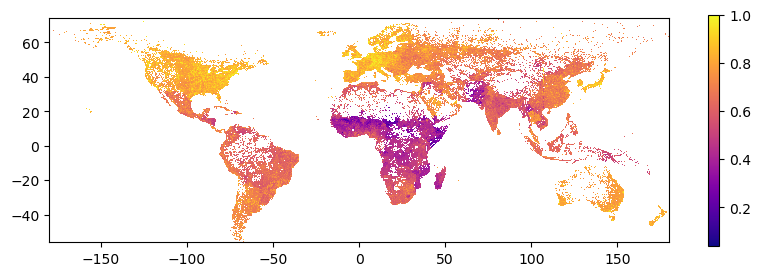

In [83]:
fig, ax = plt.subplots(figsize=(10,3))
a = ax.imshow(raster, interpolation="nearest", extent=extent, cmap="plasma")

fig.colorbar(a)

####  Write grid data product as a raster

In [86]:
meta = {'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': np.nan,
 'width': 3600,
 'height': 1300,
 'count': 1,
'crs': "EPSG:4326",
'transform': Affine(0.1, 0.0, extent[0],
        0.0, -0.1, extent[3])
       }

raster_outpath = (data_dir + "preds/"
           "hdi_raster_predictions.tif")

with rasterio.open(raster_outpath , "w", **meta) as dest:
     dest.write(np.array([raster]))